# Use updated parameters and analysis to calculate the flux of a torsion

Let's do it right this time. I'm going to make all the code self-contained here (except modules, of course) so that we can easily debug (and play) with the remotely.

In [15]:
from __future__ import division, print_function
import numpy as np
import scipy as sc
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
import math as math
from math import pi
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.ticker import FormatStrFormatter
import decimal
import sys
from numpy import genfromtxt
import glob
import datetime
import inspect
import os as os

%load_ext autoreload
%autoreload 2
%matplotlib inline

import seaborn as sns
sns.set(style='ticks', palette='Set2')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simple accessory functions

In [16]:
def data_to_energy(histogram, kT):
    """
    This function takes in population histograms from Chris' PKA data and
    (a) smoothes them with a Gaussian kernel with width 1;
    (b) eliminates zeros by setting any zero value to the minimum of the data;
    (c) turns the pouplation histograms to energy surfaces.
    Assumption: `histogram` is 1-dimensional.
    N.B. These have been reinterpreted as chemical-potential-like quantities.
    """
    bins = len(histogram)
    histogram_smooth = gaussian_filter(histogram, 1)
    histogram_copy = np.copy(histogram_smooth)
    for i in range(bins):
        if histogram_smooth[i] != 0:
            histogram_copy[i] = histogram_smooth[i]
        else:
            histogram_copy[i] = min(histogram_smooth[np.nonzero(histogram_smooth)])
    histogram_smooth = histogram_copy
    assert(not np.any(histogram_smooth == 0))
    
    energy = -kT * np.log(histogram_smooth)
    return energy


In [17]:
def check_for_zeros(surface):
    """
    This function takes in a population histogram (or energy surface) and
    (a) checks to see if there are any zero values;
    (b) reports how many; and
    (c) notifies the user if there are more than 3 consecutive zeros.
    Assumption: the `surface` is 1-dimensional.
    """
    # First, are there any zeros?
    diff = len(surface) - len(surface[np.nonzero(surface)])
    if diff > 0:
        print("Array contains {} zeros.".format(diff))
        # print(surface==0)
        condition = surface == 0
        idx = np.where(surface == 0)[0]
        # http://stackoverflow.com/questions/24342047/count-consecutive-occurences-of-values-varying-in-length-in-a-numpy-array
        # Maximum length of place where there's True...
        tmp = np.diff(np.where(np.concatenate(([condition[0]], condition[:-1] != condition[1:],
                                     [True])))[0])[::2]
        if max(tmp) >= 3:
            print("Surface contains {} consecutive zeros.".format(max(tmp)))
            print("The location of the zeros are {}".format(idx))
            print(surface)

    else:
        pass

In [18]:
def plot_energies(unbound, bound):
    fig = plt.figure(figsize=(12,12))
    gs = GridSpec(2, 2, wspace=0.2, hspace=0.5)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax1.plot(range(bins), unbound, c='r')
    ax1.set_title('Unbound chemical-potential-like energies', y=1.05)
    
    ax2.plot(range(bins), bound, c='b')
    ax2.set_title('Bound chemical-potential-like energies', y=1.05)
    plt.show()

In [46]:
def plot_steady_state(ss, PDF_unbound, PDF_bound):
    fig = plt.figure(figsize=(12,12))
    gs = GridSpec(2, 2, wspace=0.2, hspace=0.5)
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax1.plot(range(bins), ss[0:bins], c='r')
    ax1.plot(range(bins), PDF_unbound, c='k', alpha=0.5 )
    ax1.set_title('Unbound steady-state', y=1.05)
    
    ax2.plot(range(bins), ss[bins:2*bins], c='b')
    ax2.plot(range(bins), PDF_bound, c='k', alpha=0.5)
    ax2.set_title('Bound steady-state', y=1.05)
    plt.show()

In [47]:
def plot_transition_matrix(matrix, title=None, name=None, source_code=None, text=None):

    # Plot the FULL transition matrix
    f, (ax1) = plt.subplots(1, figsize=(8,8), facecolor='white')
    cmap = mpl.cm.jet
    masked = np.copy(matrix)
    masked[masked == 0.0] = np.nan
    im3 = ax1.imshow(masked, interpolation='none', cmap=cmap, alpha=0.3, vmin=0, vmax=1)
    divider3 = make_axes_locatable(ax1)
    cax3 = divider3.append_axes("right", size="10%", pad=0.05)
    cbar3 = plt.colorbar(im3, cax=cax3, ticks=MultipleLocator(0.2), format="%.2f")

    if text:
        for x_val in range(len(masked[0])):
            for y_val in range(len(masked[1])):
                # Because flippin' imshow, man.
                c = '{:.3f}'.format(masked[y_val][x_val]) if not np.isnan(masked[x_val][y_val]) else ''
                ax1.text(x_val, y_val, c, va='center', ha='center', fontsize=10)

    ax1.grid(None)
    ax1.set_ylabel('From bin in rows')
    ax1.set_xlabel('To bin in columns')
    if title:
        ax1.set_title(title, size=20, y=1.0)

    plt.tight_layout()
    plt.show()

## Code parameters and assumptions

In [360]:
def saw(x, a):
    return 2 * (x / a - np.floor(1/2 + x/a))

In [ ]:
# This is really `RT` now, but `kT` is littered throughout the code, and I think our meaning will be clear.
# kT = 0.6                       # kcal mol**-1    
# C_intersurface = 0.24          # micromolar**-1 second**-1
# C_intrasurface = 2.28 * 10**13 # second**-1
# cATP = 30                      # micromolar
# offset_factor = 6.25           # kcal mol**-1
# catalytic_rate = 140           # second**-1
# dx = 1                         # by definition

# p = {
#     'kT' : 0.6,
#     'C_intersurface' : 0.24,
#     'C_intrasurface' : 0.24,
#     'cATP' : 30,
#     'offset_factor' : 0,
#     'catalytic_rate' : 0,
#     'dx' : 1
# }

In [657]:
class simulation(object):
    
    def plot_energy(self):
        fig = plt.figure(figsize=(12,12))
        gs = GridSpec(2, 2, wspace=0.2, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[0, 1])
        ax1.plot(range(self.bins), self.unbound, c='r')
        ax1.set_title('Unbound chemical-potential-like energies', y=1.05)
        ax2.plot(range(self.bins), self.bound, c='b')
        ax2.set_title('Bound chemical-potential-like energies', y=1.05)
        plt.show()
        
    def plot_ss(self):
        boltzmann_unbound  = np.exp(-self.unbound/kT)
        boltzmann_bound = np.exp(-self.bound/kT)
        self.PDF_unbound = boltzmann_unbound / np.sum((boltzmann_unbound)*self.dx)
        self.PDF_bound   = boltzmann_bound / np.sum((boltzmann_bound)*self.dx)
        
        fig = plt.figure(figsize=(12,12))
        gs = GridSpec(2, 2, wspace=0.2, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[0, 1])
        ax1.plot(range(self.bins), self.ss[0:bins], c='r', label='SS')
        ax1.plot(range(self.bins), self.PDF_unbound, c='k', label='PDF' )
        ax1.legend()
        ax1.set_title('Unbound steady-state', y=1.05)

        ax2.plot(range(self.bins), self.ss[bins:2*bins], c='b', label='SS')
        ax2.plot(range(self.bins), self.PDF_bound, c='k', label='PDF')
        ax2.set_title('Bound steady-state', y=1.05)
        ax2.legend()
        plt.show()
        
    def plot_flux(self, label=None):
        fig = plt.figure(figsize=(12,12))
        gs = GridSpec(2, 1, wspace=0.2, hspace=0.5)
        ax1 = plt.subplot(gs[0, 0])
        ax1.plot(range(self.bins), self.flux_u, c='r', label='U')
        ax1.plot(range(self.bins), self.flux_b, c='b', label='B')
        ax1.plot(range(self.bins), self.flux_b+self.flux_u, c='k', label='U+B' )
        ax1.legend()
        if label is not None:
            ax1.set_title('{}: C_u = {:6.2e}, C_ub = {}, catalysis = {}, cATP = {}'.format(label, self.C_intrasurface, self.C_intersurface, self.catalytic_rate, self.cATP), y=1.05)
        else:
            ax1.set_title('C_u = {:6.2e}, C_ub = {}, catalysis = {}, cATP = {}'.format(self.C_intrasurface, self.C_intersurface, self.catalytic_rate, self.cATP), y=1.05)
        plt.show()

        
    def calculate_intrasurface_rates(self, energy_surface):
        forward_rates = self.C_intrasurface * np.exp(-1 * np.diff(energy_surface) / float(2 * self.kT))
        backward_rates = self.C_intrasurface * np.exp(+1 * np.diff(energy_surface) / float(2 * self.kT))
        rate_matrix = np.zeros((self.bins, self.bins))
        for i in range(self.bins - 1):
            rate_matrix[i][i + 1] = forward_rates[i]
            rate_matrix[i + 1][i] = backward_rates[i]
        rate_matrix[0][bins - 1] = self.C_intrasurface * np.exp(-(energy_surface[bins - 1] - energy_surface[0]) / float(2 * self.kT))
        rate_matrix[bins - 1][0] = self.C_intrasurface * np.exp(+(energy_surface[bins - 1] - energy_surface[0]) / float(2 * self.kT))
        return rate_matrix
    
    def calculate_intersurface_rates(self, unbound_surface, bound_surface):
        bu_rm = np.empty((self.bins))
        ub_rm = np.empty((self.bins))
        for i in range(self.bins):
            bu_rm[i] = (self.C_intersurface *
                        np.exp(-1 * (bound_surface[i] - unbound_surface[i]) / float(self.kT)) + 
                              self.catalytic_rate)
            ub_rm[i] = self.C_intersurface * self.cATP 
        return ub_rm, bu_rm
    
    def compose_tm(self, u_rm, b_rm, ub_rm, bu_rm):
        tm = np.zeros((2*self.bins, 2*self.bins))
        tm[0:self.bins, 0:self.bins] = u_rm
        tm[self.bins:2*self.bins, self.bins:2*self.bins] =  b_rm
        for i in range(self.bins):
            tm[i, i + self.bins] = ub_rm[i]
            tm[i + self.bins, i] = bu_rm[i]
        self.tm = self.scale_tm(tm)
        return
    
    def scale_tm(self, tm):
        row_sums = tm.sum(axis=1, keepdims=True)
        maximum_row_sum = int(math.log10(max(row_sums)))
        print('Maximum row sum is {}'.format(max(row_sums)))
        # maximum_rate_constant_order = int(math.log10(tm.max()))
        # self.dt = 10 ** -(maximum_rate_constant_order + 1 + 1)
        self.dt = 10 ** -(maximum_row_sum + 1)
        print('dt = {}'.format(self.dt))
        # tm_scaled = np.multiply(tm, dt)
        tm_scaled = self.dt * tm
        row_sums = tm_scaled.sum(axis=1, keepdims=True)
        print('Now maximum row sum is {}'.format(max(row_sums)))
        if np.any(row_sums > 1):
            print('Row sums unexpectedly greater than 1.')
            print(row_sums)
        for i in range(2 * self.bins):
            tm_scaled[i][i] = 1.0 - row_sums[i]
        return tm_scaled
    
    def calculate_eigenvector(self, tm):
        eigenvalues, eigenvectors = np.linalg.eig(tm.T)
        ss = eigenvectors[:, eigenvalues.argmax()].astype(float)
        print('Maximum eigenvalue = {}'.format(eigenvalues[eigenvalues.argmax()]))
        self.ss = ss/np.sum(ss)
        return
        
        
    def calculate_flux(self, ss, tm):
        flux_u = np.empty((self.bins))
        flux_b = np.empty((self.bins))
        for i in range(self.bins):
            if i == 0:
                flux_u[i] = - ss[i] * tm[i][i + 1]/dt + ss[i + 1] * tm[i + 1][i]/dt
            if i == bins - 1:
                flux_u[i] = - ss[i] * tm[i][0]/dt + ss[0] * tm[0][i]/dt
            else:
                flux_u[i] = - ss[i] * tm[i][i + 1]/dt + ss[i + 1] * tm[i + 1][i]/dt                    
        for i in range(self.bins, 2*self.bins):
            if i == bins:
                flux_b[i - self.bins] = - ss[i] * tm[i][i + 1]/dt + ss[i + 1] * tm[i + 1][i]/dt
            if i == 2 * self.bins - 1:
                flux_b[i - self.bins] = - ss[i] * tm[i][self.bins]/dt + ss[self.bins] * tm[self.bins][i]/dt
            else:
                flux_b[i - self.bins] = - ss[i] * tm[i][i + 1]/dt + ss[i + 1] * tm[i + 1][i]/dt
        self.flux_u = flux_u
        self.flux_b = flux_b
        return
    
    def iterate(self, iterations=None):
        population = np.random.rand(2*self.bins)
        row_sums = population.sum(axis=0, keepdims=True)
        population = population / row_sums
        iterations = 0
        if self.ss is not None:
            new_population = self.ss
        for i in range(iterations):
            new_population = np.dot(new_population, self.tm)    
        self.iterative_ss = new_population
        return
    
    def simulate(self):
        u_rm = self.calculate_intrasurface_rates(self.unbound)
        b_rm = self.calculate_intrasurface_rates(self.bound)
        ub_rm, bu_rm = self.calculate_intersurface_rates(self.unbound, self.bound)
        self.compose_tm(u_rm, b_rm, ub_rm, bu_rm)
        self.calculate_eigenvector(self.tm)
        self.calculate_flux(self.ss, self.tm)
        #self.plot_flux(label='Eigenvector method')
        #self.iterate(iterations)
        #self.calculate_flux(self.iterative_ss, self.tm)
        #self.plot_flux(label='Iterative method')
        return
        
    
    def __init__(self):
            
        self.kT = 0.6
        self.C_intersurface = 0.24
        self.C_intrasurface = 2.28 * 10 ** 13
        self.cATP = 30
        self.offset_factor = 6.25
        self.catalytic_rate = 140
        self.dx = 1
        self.unbound = np.array([saw(i, 20) for i in range(20)])
        self.bound = np.array([saw(i+10, 20) for i in range(20)])
        self.bins = len(self.unbound)

Maximum eigenvalue = 1.0000000000000022
Iterative method with random population enabled.
Maximum eigenvalue = 1.0000000000000022
Iterative method with random population enabled.
Maximum eigenvalue = 1.0000000000000022
Iterative method with random population enabled.
Maximum eigenvalue = 1.0000000000000022
Iterative method with random population enabled.
Maximum eigenvalue = 1.0000000000000022
Iterative method with random population enabled.
Maximum eigenvalue = 1.0000000000000022
Iterative method with random population enabled.
Maximum eigenvalue = 1.0000000000000022
Iterative method with random population enabled.
Maximum eigenvalue = 1.0000000000000022
Iterative method with random population enabled.
Maximum eigenvalue = 1.0000000000000022
Iterative method with random population enabled.
Maximum eigenvalue = 1.0000000000000022
Iterative method with random population enabled.
Maximum eigenvalue = 1.0000000000000022
Iterative method with random population enabled.


/home/dslochower/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



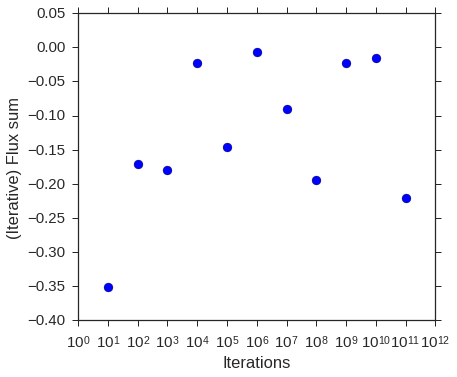

In [608]:
def variable_saw(y, x, a):
    return y * (x / a - np.floor(1/2 + x/a))

fig = plt.figure()
ax = plt.subplot(111)
clr = sns.color_palette("Blues", 21)
k = 0

for j in np.arange(1, 12, 1):
    iterations = 10**j
    w = simulation()
    w.cATP = 10000
    w.unbound =  np.array([variable_saw(1.7, i, 20) for i in range(20)])
    w.bound =  np.array([variable_saw(1.7, i+10, 20) for i in range(20)])
    w.simulate()
    w.iterate(iterations)
    w.calculate_flux(w.iterative_ss, w.tm)
    plt.scatter(iterations, np.sum(w.flux_u+w.flux_b), s=80)
    k += 1
    if j == 1:
        mini = np.sum(w.flux_u+w.flux_b)
        maxi = np.sum(w.flux_u+w.flux_b)
    else:
        if np.sum(w.flux_u+w.flux_b) < mini:
            mini = np.sum(w.flux_u+w.flux_b)
        if np.sum(w.flux_u+w.flux_b) > maxi:
            maxi = np.sum(w.flux_u+w.flux_b)
            
plt.ylabel('(Iterative) Flux sum')
plt.xlabel('Iterations')
plt.xscale('log')
#plt.xlim([1.6,2.0])
# plt.ylim([-20e-14, 10e-11])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


Maximum eigenvalue = 1.0000000000000022
Maximum eigenvalue = 1.0000000000000002
Maximum eigenvalue = 0.999999999999999
Maximum eigenvalue = 0.9999999999999994
Maximum eigenvalue = 0.9999999999999978
Maximum eigenvalue = 0.9999999999999987
Maximum eigenvalue = 0.9999999999999972
Maximum eigenvalue = 1.0000000000000029
Maximum eigenvalue = 1.0000000000000038
Maximum eigenvalue = 1.0000000000000013
Maximum eigenvalue = 0.9999999999999993
Maximum eigenvalue = 1.000000000000001
Maximum eigenvalue = 1.0000000000000016
Maximum eigenvalue = 1.0000000000000007
Maximum eigenvalue = 0.9999999999999988
Maximum eigenvalue = 1.000000000000002
Maximum eigenvalue = 1.0000000000000016
Maximum eigenvalue = 0.9999999999999987
Maximum eigenvalue = 0.9999999999999983
Maximum eigenvalue = 1.0000000000000016


/home/dslochower/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning:

No labelled objects found. Use label='...' kwarg on individual plots.



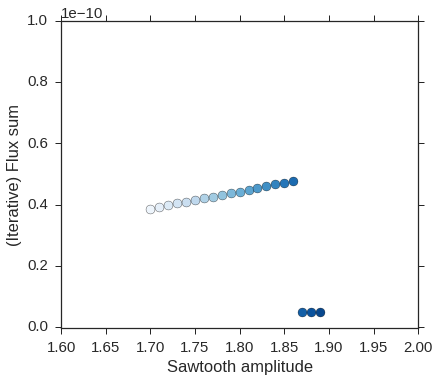

In [582]:
def variable_saw(y, x, a):
    return y * (x / a - np.floor(1/2 + x/a))

fig = plt.figure()
ax = plt.subplot(111)
clr = sns.color_palette("Blues", 21)
k = 0

flux_amplitude = np.zeros((21, 2))

for j in np.arange(1.7, 1.9,0.01):
    w = simulation()
    w.cATP = 10000
    w.unbound =  np.array([variable_saw(j, i, 20) for i in range(20)])
    w.bound =  np.array([variable_saw(j, i+10, 20) for i in range(20)])
    w.simulate()
    plt.scatter(j, np.sum(w.flux_u+w.flux_b), c=clr[k], s=80)
    k += 1
    if j == 1:
        mini = np.sum(w.flux_u+w.flux_b)
        maxi = np.sum(w.flux_u+w.flux_b)
    else:
        if np.sum(w.flux_u+w.flux_b) < mini:
            mini = np.sum(w.flux_u+w.flux_b)
        if np.sum(w.flux_u+w.flux_b) > maxi:
            maxi = np.sum(w.flux_u+w.flux_b)
    flux_amplitude[k, 0] = np.sum(w.flux_u+w.flux_b)
    flux_amplitude[k, 1] = j

plt.ylabel('(Iterative) Flux sum')
plt.xlabel('Sawtooth amplitude')
plt.xlim([1.6,2.0])
plt.ylim([-20e-14, 10e-11])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# print('Min = {}, Max = {}'.format(mini, maxi))
np.savetxt('iterative-method-v2-flux-vs-amplitude-from-1.7-to-1.9-by-0.01.txt', flux_amplitude, fmt='%.18e', delimiter=' ')


In [562]:
it = np.loadtxt('iterative-method-flux-vs-amplitude-from-1-to-30-by-0.2.txt')
ei = np.loadtxt('flux-vs-amplitude-from-1-to-30-by-0.2.txt')

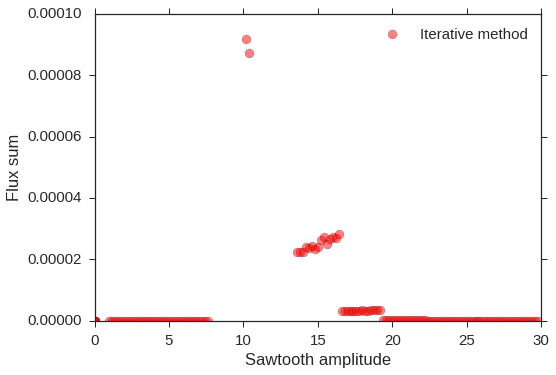

In [572]:
plt.figure()
plt.scatter(it[:,1], it[:,0], c='r', label='Iterative method', s=80, alpha= 0.5)
# plt.scatter(ei[:,1], ei[:,0], c='b', label='Eigenvalue method', s=80, alpha=0.5)
plt.xlabel('Sawtooth amplitude')
plt.ylabel('Flux sum')
plt.xlim([0, 30])
# plt.ylim([-20e-14, 10e-9])
plt.ylim([-20e-14, 1e-4])
plt.legend()
plt.show()

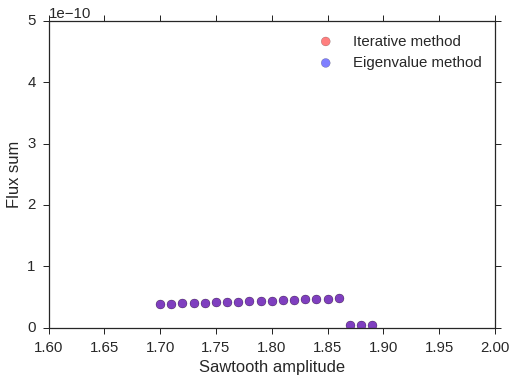

In [583]:
it = np.loadtxt('iterative-method-v2-flux-vs-amplitude-from-1.7-to-1.9-by-0.01.txt')
ei = np.loadtxt('flux-vs-amplitude-from-1.7-to-1.9-by-0.01.txt')
plt.figure()
plt.scatter(it[:,1], it[:,0], c='r', label='Iterative method', s=80, alpha= 0.5)
plt.scatter(ei[:,1], ei[:,0], c='b', label='Eigenvalue method', s=80, alpha=0.5)
plt.xlabel('Sawtooth amplitude')
plt.ylabel('Flux sum')
plt.xlim([1.6, 2.0])
# plt.ylim([-20e-14, 10e-9])
plt.ylim([-20e-14, 5e-10])
plt.legend()
plt.show()

Row sums unexpectedly greater than 1.
[[  4.575842498503e+11]
 [  4.575842498503e+11]
 [  4.575842498503e+11]
 [  4.575842498503e+11]
 [  4.575842498503e+11]
 [  4.575842498503e+11]
 [  4.575842498503e+11]
 [  4.575842498503e+11]
 [  4.575842498503e+11]
 [  1.358439971143e+12]
 [  2.565761684877e+11]
 [  4.575842498503e+11]
 [  4.575842498503e+11]
 [  4.575842498503e+11]
 [  4.575842498503e+11]
 [  4.575842498503e+11]
 [  4.575842498503e+11]
 [  4.575842498503e+11]
 [  4.575842498503e+11]
 [  4.575842498503e+11]
 [  2.565761684651e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  4.575842498277e+11]
 [  1.358439971120e+12]]
M

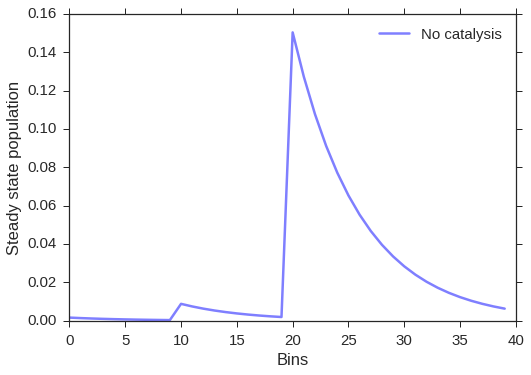

In [621]:
def variable_saw(y, x, a):
    return y * (x / a - np.floor(1/2 + x/a))

fig = plt.figure()
ax = plt.subplot(111)
clr = sns.color_palette("Blues", 21)


w = simulation()
w.cATP = 10000
w.catalysis=0
w.simulate()
plt.plot(range(2*w.bins), w.ss, c='b', label='No catalysis', alpha=0.5)

# w = simulation()
# w.cATP = 10000
# w.catalysis=2*10**20
# w.simulate()
# plt.plot(range(2*w.bins), w.ss, c='r', label='Catalysis = 1400/s', alpha=0.5)


plt.ylabel('Steady state population')
plt.xlabel('Bins')
#plt.xlim([1.6,2.0])
#plt.ylim([-20e-14, 10e-11])

# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.show()


Maximum row sum is [  1.358439971143e+14]
dt = 1e-15
Now maximum row sum is [ 0.135843997114]
Maximum eigenvalue = 1.0000000000000033


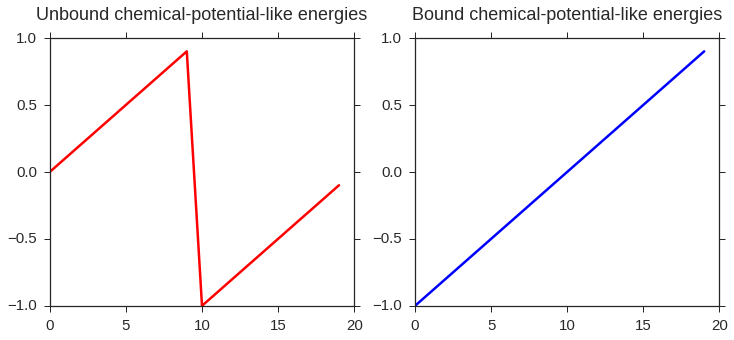

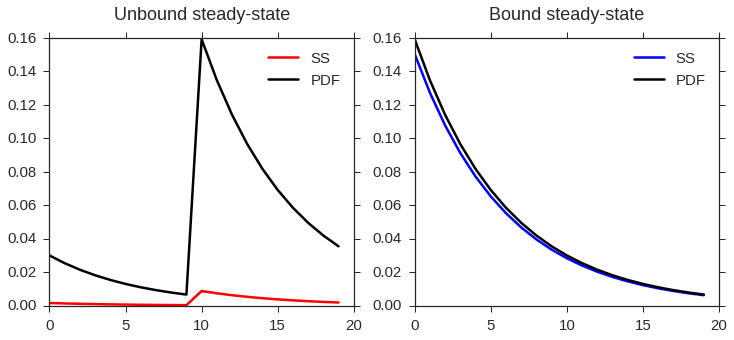

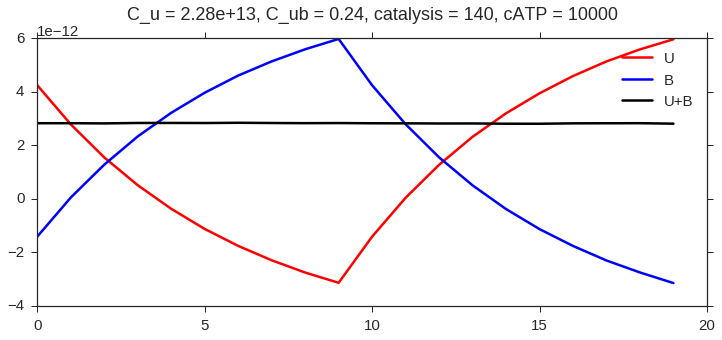

In [658]:
test = simulation()
test.cATP = 10000
test.catalysis=0
test.simulate()

test.plot_energy()
test.plot_ss()
test.plot_flux()

In [645]:
max(test.tm.sum(axis=1, keepdims=True))

array([ 1.000062676447])

In [ ]:

dir              = '/home/dslochower/Dropbox/DavidS/ProteinKinaseATorsions/'
# Sorting is important!
unbound_files    = [dir+'apo/'+'psiLEU270_chi_pop_hist_targ.txt']
bound_files      = [dir+'atpmg/'+'psiLEU270_chi_pop_hist_ref.txt']

for i in range(len(unbound_files)):
    # Preliminary read and checking
    ###############################
    name = os.path.splitext(os.path.basename(unbound_files[i]))[0]
    unbound = genfromtxt(unbound_files[i], delimiter=',', skip_header=1)
    bound = genfromtxt(bound_files[i], delimiter=',', skip_header=1)
    unbound_name = unbound_files[i].split('/')[-1].split('_')[0]
    bound_name = bound_files[i].split('/')[-1].split('_')[0]
    assert(unbound_name == bound_name)
    unbound_energies = data_to_energy(unbound, kT)
    bound_energies   = data_to_energy(bound, kT)
    bins = len(unbound)
    
        
    def saw(x, a):
        return 2 * (x / a - np.floor(1/2 + x/a))
    unbound_energies = np.array([saw(i, 20) for i in range(20)])
    bound_energies = np.array([saw(i+20/2, 20) for i in range(20)])
    bins=len(unbound_energies)
    
    # Calculate the energy offset
    #############################
    e_offset = offset_factor
    
    print('Energy offset is {}'.format(e_offset))
    unbound_energies += e_offset
    
    # Calculate intra-surface rate matrices
    #######################################
    def rate_matrix(C_intrasurface, energy_surface, kT):
        bins = len(energy_surface)
        forward_rates = C_intrasurface * np.exp(-1 * np.diff(energy_surface) /
                                   float(2 * kT))
        backward_rates = C_intrasurface * np.exp(+1 * np.diff(energy_surface) /
                                    float(2 * kT))
        rate_matrix = np.zeros((bins, bins))
        for i in range(bins - 1):
            rate_matrix[i][i + 1] = forward_rates[i]
            rate_matrix[i + 1][i] = backward_rates[i]
        rate_matrix[0][bins - 1] = C_intrasurface * np.exp(-(energy_surface[bins - 1] -
                                                energy_surface[0]) / float(2 * kT))
        rate_matrix[bins - 1][0] = C_intrasurface * np.exp(+(energy_surface[bins - 1] -
                                                energy_surface[0]) / float(2 * kT))

        return rate_matrix
    unbound_rate_matrix = rate_matrix(C_intrasurface, unbound_energies, kT)
    bound_rate_matrix = rate_matrix(C_intrasurface, bound_energies, kT)
    
    # Calculate inter-surface rate matrices
    #######################################
    unbound_to_bound = np.zeros((bins))
    bound_to_unbound = np.zeros((bins))
    for i in range(bins):
        bound_to_unbound[i] = (C_intersurface *
                              np.exp(-1 * (bound_energies[i] - unbound_energies[i]) / float(kT)) + 
                              catalytic_rate)
        unbound_to_bound[i] = C_intersurface * cATP 

    
    # Write the transition matrix
    #############################
    transition_matrix = np.zeros((2 * bins, 2 * bins))
    transition_matrix[0:bins, 0:bins] = unbound_rate_matrix
    transition_matrix[bins:2 * bins, bins:2 * bins] = bound_rate_matrix
    for i in range(bins):
        transition_matrix[i, i + bins] = unbound_to_bound[i]
        transition_matrix[i + bins, i] = bound_to_unbound[i]

    # Scale the transition matrix by dt
    ###################################
    maximum_rate_constant_order = int(math.log10(transition_matrix.max()))
    dt = 10 ** -(maximum_rate_constant_order + 2)
    transition_matrix = np.multiply(transition_matrix, dt)

    # Make sure the transition matrix is normalzied
    ###############################################
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    if np.any(row_sums > 1):
        print('Row sums unexpectedly greater than 1.')
        print(row_sums)
    for i in range(2 * bins):
        transition_matrix[i][i] = 1.0 - row_sums[i]
    # row_sums = transition_matrix.sum(axis=0)
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    
    # Calculate eignevectors and flux
    #################################
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
    ss = eigenvectors[:, eigenvalues.argmax()].astype(float)
    print('Maximum eigenvalue = {}'.format(eigenvalues[eigenvalues.argmax()]))
    ss /= np.sum(ss)
    boltzmann_unbound  = np.exp(-unbound_energies/kT)
    boltzmann_bound = np.exp(-bound_energies/kT)
    PDF_unbound = boltzmann_unbound / np.sum((boltzmann_unbound)*dx)
    PDF_bound   = boltzmann_bound / np.sum((boltzmann_bound)*dx)

    
    #print('test = {}'.format(np.dot(transition_matrix, tmp)))
    #print('test2 = {}'.format(transition_matrix))
    
#     def iterate(k, tm):
#         one = np.array([1/(2*bins)]*(2*bins))
#         tmp = tm.dot(one)
#         for _ in range(k):
#             tmp = tm.dot(tmp)
#         return tmp

    
#     print('Unscaled TM = {}'.format(transition_matrix))
    
#     plt.figure()
#     for i in [1, 10, 100, 1000, 10000, 100000, 1000000]:
#         plt.scatter(i, np.sum(one - iterate(i, transition_matrix)), s=80)
#     plt.xscale('log')
#     plt.show()

#     iterative_ss = iterate(1000, transition_matrix)
    
    
    population = np.random.rand(2*bins)
    row_sums = population.sum(axis=0, keepdims=True)
    population = population / row_sums
    iterations = 0
    diff = []
    new_population = population

    for i in range(10000000):
        new_population = np.dot(new_population, transition_matrix)    
    iterative_ss = new_population
    
    
    # Check plots
    #############
    plot_energies(unbound_energies, bound_energies)
    plot_steady_state(ss, PDF_unbound, PDF_bound)
    plot_steady_state(iterative_ss, PDF_unbound, PDF_bound)
    
    # Calculate the flux across bin boundaries
    ##########################################
    # Flux across boundaries
    flux_u = np.empty((bins))
    for i in range(bins):
            if i == 0:
                flux_u[i] = (
                            - ss[i]           * transition_matrix[i][i + 1]/dt + ss[i + 1]       * transition_matrix[i + 1][i]/dt
                            )
            if i == bins - 1:
                flux_u[i] = (
                            - ss[i]        * transition_matrix[i][0]/dt + ss[0]        * transition_matrix[0][i]/dt
                            )

            else:
                flux_u[i] = (
                            - ss[i]        * transition_matrix[i][i + 1]/dt + ss[i + 1]    * transition_matrix[i + 1][i]/dt
                            )
    flux_b = np.empty((bins))
    for i in range(bins, 2 * bins):
            if i == bins:
                flux_b[i - bins] = (
                                   - ss[i]            * transition_matrix[i][i + 1]/dt + ss[i + 1]        * transition_matrix[i + 1][i]/dt
                                   )
            if i == 2 * bins - 1:
                flux_b[i - bins] = (
                                   - ss[i]        * transition_matrix[i][bins]/dt + ss[bins]     * transition_matrix[bins][i]/dt
                                   )

            else:
                flux_b[i - bins] = (
                                   - ss[i]* transition_matrix[i][i + 1]/dt + ss[i + 1] * transition_matrix[i + 1][i]/dt
                                   )
    flux_ub = np.empty((bins))
    for i in range(bins):
                flux_ub[i] = (
                             - ss[i]            * transition_matrix[i][i + bins]/dt + ss[i + bins]     * transition_matrix[i + bins][i]/dt
                             )
            
            
    # Calculate flux using the iterative method steady-state population
    flux_u_it = np.empty((bins))
    for i in range(bins):
            if i == 0:
                flux_u_it[i] = (
                            - iterative_ss[i]           * transition_matrix[i][i + 1]/dt + iterative_ss[i + 1]       * transition_matrix[i + 1][i]/dt
                            )
            if i == bins - 1:
                flux_u_it[i] = (
                            - iterative_ss[i]        * transition_matrix[i][0]/dt + iterative_ss[0]        * transition_matrix[0][i]/dt
                            )

            else:
                flux_u_it[i] = (
                            - iterative_ss[i]        * transition_matrix[i][i + 1]/dt + iterative_ss[i + 1]    * transition_matrix[i + 1][i]/dt
                            )
    flux_b_it = np.empty((bins))
    for i in range(bins, 2 * bins):
            if i == bins:
                flux_b_it[i - bins] = (
                                   - iterative_ss[i]            * transition_matrix[i][i + 1]/dt + iterative_ss[i + 1]        * transition_matrix[i + 1][i]/dt
                                   )
            if i == 2 * bins - 1:
                flux_b_it[i - bins] = (
                                   - iterative_ss[i]        * transition_matrix[i][bins]/dt + iterative_ss[bins]     * transition_matrix[bins][i]/dt
                                   )

            else:
                flux_b_it[i - bins] = (
                                   - iterative_ss[i]* transition_matrix[i][i + 1]/dt + iterative_ss[i + 1] * transition_matrix[i + 1][i]/dt
                                   )
            
    np.set_printoptions(precision=12)        
    print('Unbound ss: {}'.format(ss[0:bins]))       
    print('Bound ss: {}'.format(ss[bins:2*bins]))
    
    print('Unbound it: {}'.format(iterative_ss[0:bins]))
    print('Bound it: {}'.format(iterative_ss[bins:2*bins]))
    
#    print('Transition matrix unbound: {}'.format([transition_matrix[i][i+1]/dt for i in range(bins-1)]))
#    print('Transition matrix bound: {}'.format([transition_matrix[i+bins][i+bins+1]/dt for i in range(bins-1)]))
       
    
    print('Flux across unbound surface is {}'.format(flux_u))
    print('Flux across bound surface is {}'.format(flux_b))
#    print('Intrasurface flux sum {}'.format(flux_u+flux_b))

    print('Flux across unbound from iterative is {}'.format(flux_u_it))
    print('Flux across bound from iterative is {}'.format(flux_b_it))

    
    

plt.figure()
plt.plot(range(bins), flux_u, c='r')
plt.plot(range(bins), flux_b, c='b')
plt.plot(range(bins), flux_u+flux_b, c='k')
plt.title('Flux calculated using eigenvector')
plt.show()


plt.figure()
plt.plot(range(bins), flux_u_it, c='r')
plt.plot(range(bins), flux_b_it, c='b')
plt.plot(range(bins), flux_u_it+flux_b_it, c='k')
plt.title('Flux calculated using iterative method')
plt.show()

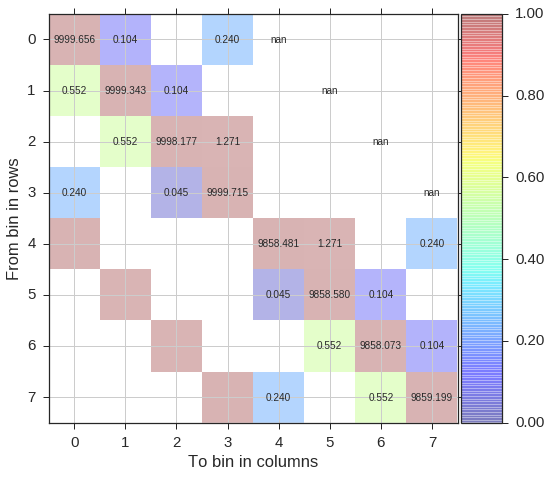

In [97]:
plot_transition_matrix(transition_matrix/dt, text=True)